# Project Proposal on Comparative Analysis of Residential Home Sales in East Hartford and West Hartford



## Introduction

### Background Info
Different areas have different price distributions and variability which may be a crucial factor in someone’s plans for the next few years of their life. Therefore, understanding the housing market and real estate trends is very important when potential homebuyers want to make informed decisions before buying. There are many ways to be more informed, ranging from official legislature setting a bar for how professional agents better serve consumers with their needs and interests in mind, to personal research that one does on the side.

### Project Question
What is the median sale price and the standard deviation of residential properties in two different towns, East Hartford and West Hartford, segmented by residential type?

### Data Set
We will be using the Real Estate Sales 2001-2020 GL data set from the Data.gov data catalog. It contains records about real estate sales over $2,000 in the US state of Connecticut between the years of 2001 to 2020, including information about the year of listing, town, assessed value, sale amount, property type, and residential type. 


## Preliminary Results

First we wrangle the data and plot it before doing our preliminary analysis

In [1]:
# loading in libraries
library(tidyverse)
library(tidymodels)
library(janitor)
library(infer)
options(repr.plot.width = 6, repr.plot.height =5) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Wrangling Dataset

In [2]:
# data set url
url <- "https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD"

# read data 
real_estate_data <- read_csv(url) |>
    clean_names()

head(real_estate_data)

Rows: 997213 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Date Recorded, Town, Address, Property Type, Residential Type, Non ...
dbl (5): Serial Number, List Year, Assessed Value, Sale Amount, Sales Ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type,non_use_code,assessor_remarks,opm_remarks,location
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000,248400,0.5354,Residential,Single Family,NA,NA,NA,POINT (-73.06822 41.35014)
2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500,239900,0.4606,Residential,Three Family,NA,NA,NA,NA
2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500,325000,0.4630,Commercial,NA,NA,NA,NA,NA
2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400,202500,0.6291,Residential,Two Family,NA,NA,NA,NA
200500,2020,09/07/2021,Avon,245 NEW ROAD,217640,400000,0.5441,Residential,Single Family,NA,NA,NA,NA
200121,2020,12/15/2020,Avon,63 NORTHGATE,528490,775000,0.6819,Residential,Single Family,NA,NA,NA,POINT (-72.89675 41.79445)


In [3]:
# keeping only relevant columns and filtering out houses sold before 2017 to decrease the effect of inflation
real_estate_selected <- real_estate_data |>
    select(town, list_year, assessed_value, sale_amount, residential_type) %>%
    filter(!is.na(list_year), !is.na(sale_amount), !is.na(residential_type), !is.na(town), !is.na(assessed_value), list_year >= 2017)
head(real_estate_selected)

# keeping only the two towns of interest
filtered_real_estate <- real_estate_selected %>%
    filter(town == "West Hartford" | town == "East Hartford")
head(filtered_real_estate)

town,list_year,assessed_value,sale_amount,residential_type
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Ashford,2020,253000,430000,Single Family
Avon,2020,130400,179900,Condo
Avon,2020,619290,890000,Single Family
Avon,2020,862330,1447500,Single Family
Avon,2020,847520,1250000,Single Family
Berlin,2020,234200,130000,Two Family


town,list_year,assessed_value,sale_amount,residential_type
<chr>,<dbl>,<dbl>,<dbl>,<chr>
West Hartford,2020,216580,305000,Single Family
West Hartford,2020,181720,327900,Single Family
West Hartford,2020,166670,305000,Condo
East Hartford,2020,87380,235000,Single Family
East Hartford,2020,73340,180000,Single Family
East Hartford,2020,99730,164000,Single Family


In [ ]:
# Looking at the number of homes sold in the two towns we are interested in
diff_town <- filtered_real_estate %>%
    group_by(town, residential_type) %>%
    summarize(n = n())
diff_town

Since we see that three and four family houses are not very common, we will remove them from our sample as they may be skewed or not provide a lot of insight. The rest of the housing types were sold quite frequently in both towns and have a reasonably sized number number of housing sales, so we should not have to worry about outliers and can continue on with the data.

In [4]:
# calculating some summary statistics about the population
real_estate_final <- filtered_real_estate %>%
    filter(residential_type == "Condo" | residential_type == "Single Family" | residential_type == "Two Family")

stats <- real_estate_final %>%
    group_by(town, residential_type) %>%
    summarize(median_assessed_value = median(assessed_value), 
              min_assessed_value = min(assessed_value), 
              max_assessed_value = max(assessed_value), 
              median_sale_amount = median(sale_amount), 
              min_sale_amount = min(sale_amount), 
              max_sale_amount = max(sale_amount), 
              median_year = median(list_year), 
              min_year = min(list_year), 
              max_year = max(list_year), 
              n = n())
head(stats)

# Generating simpler statistics regardless of residential type for preliminary analysis
stats_simple <- real_estate_final %>%
    group_by(town) %>%
    summarize(median_assessed_value = median(assessed_value),median_sale_amount = median(sale_amount), median_year = median(list_year), n = n())

head(stats_simple)

`summarise()` has grouped output by 'town'. You can override using the
`.groups` argument.


town,residential_type,median_assessed_value,min_assessed_value,max_assessed_value,median_sale_amount,min_sale_amount,max_sale_amount,median_year,min_year,max_year,n
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
East Hartford,Condo,56970,8860,1910440,84950,3000,4500000,2019,2017,2020,314
East Hartford,Single Family,100875,8000,305470,165000,1200,420000,2018,2017,2020,2528
East Hartford,Two Family,111310,54790,315700,184825,20000,355000,2019,2017,2020,216
West Hartford,Condo,145110,0,917700,215000,9000,1625000,2019,2017,2020,747
West Hartford,Single Family,203350,51030,1750000,320000,5000,1700000,2019,2017,2020,3665
West Hartford,Two Family,210280,78960,383740,350000,77500,565000,2019,2017,2020,194


town,median_assessed_value,median_sale_amount,median_year,n
<chr>,<dbl>,<dbl>,<dbl>,<int>
East Hartford,99865,162500,2019,3058
West Hartford,194250,303000,2019,4606


In [ ]:
# Plotting the distribution of the mean sale amount
east_data <- real_estate_final %>%
    filter(town == "East Hartford") 

In [ ]:
west_data <- real_estate_final %>%
    filter(town == "West Hartford") 

In [ ]:
east_plot <- east_data%>%
    ggplot() +
    geom_histogram(aes(x = sale_amount), bins = 10000, color = "green") +
    labs(x = "Sale Amount ($)", y = "Frequency", title = "Distribution of East Hartford Sale Prices") +
    geom_vline(xintercept = 162500, colour="red") + 
    xlim(0, 1000000) + 
    theme(text = element_text(size = 12))

In [ ]:
west_plot <- west_data%>%
    ggplot() +
    geom_histogram(aes(x = sale_amount), bins = 10000, color = "blue") +
    labs(x = "Sale Amount ($)", y = "Frequency", title = "Distribution of West Hartford Sale Prices") +
    geom_vline(xintercept = 303000, colour="red") + 
    xlim(0, 1000000) +
    theme(text = element_text(size = 12))

In [ ]:
east_plot

In [ ]:
west_plot

### Preliminary Analysis
After looking at the median and plots for East and West Hartford, while we see that West Hartford does seem to have a higher median, it may not be enough to immediately assume that West Hartford always has a higher median in housing sales price. Especially when it comes to bigger numbers such as the amount of money required to buy a house, it is better to be statistically sure of your analysis rather than just taking a single snapshot as the whole picture for granted.


## Methods: Plan

Hypothesis: Since both East and West Hartford both reside within Hartford we expect the median sale price of each half of the city to be the same. We will be testing this theory for the 3 most popular residential types of housing within Hartford, condos, single family houses, and two family houses. 

In other words: 
Let Se be the median sales price of housing in East Hartford and let Sw be the median sales price of housing in West Hartford.  Our null hypothesis $H_0: Se - Sw = 0$ versus $H_A: Se - Sw \neq 0$.

We will be testing our hypothesis at a $\alpha = 0.001$ significance level. Which means if our P-value does not fall below 0.001, we would fail to reject $H_0$. The reason for picking such a low value of $\alpha$ is because just from our preliminary data exploratory analysis, we can already see Hartford has on average a higher sale price. That way if we were to accept $H_0$ we would be more sure that we are unlikely to make a type 1 error.

In order to calculate our P-value we will use both bootstrapping and reshuffling to generate more copies of the sample in order to calculate P on. After generating our samples we will calculate the required summary statistics in our case being the difference in median sales price. This gives us our null distribution of which we can plot, or go straight into calculating P with. This will be done using the infer package. After we get our P value we can either reject or accept the null hypothesis depending if it's above or under our 0.001 significance level.


In [5]:
# Hypothesis test
real_estate_final <- real_estate_final |>
mutate(sale_amount = log(sale_amount))

head(real_estate_final)

obs_diff_in_means <- real_estate_final |>
specify(formula =  sale_amount ~ town) |>
calculate(stat="diff in means", order = c("West Hartford", "East Hartford"))

null_diff_in_means <-
real_estate_final %>% 
    specify(formula = sale_amount ~ town) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("West Hartford", "East Hartford"))

# visualize plot with test statistic
diff_in_means_plot <- null_diff_in_means %>%
    visualize(bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "both") + 
    xlab("Difference in means")

# get p-value
p_value <- null_diff_in_means |>
get_p_value(obs_stat = obs_diff_in_means, direction = "both")

town,list_year,assessed_value,sale_amount,residential_type
<chr>,<dbl>,<dbl>,<dbl>,<chr>
West Hartford,2020,216580,12.62807,Single Family
West Hartford,2020,181720,12.70046,Single Family
West Hartford,2020,166670,12.62807,Condo
East Hartford,2020,87380,12.36734,Single Family
East Hartford,2020,73340,12.10071,Single Family
East Hartford,2020,99730,12.00762,Single Family


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


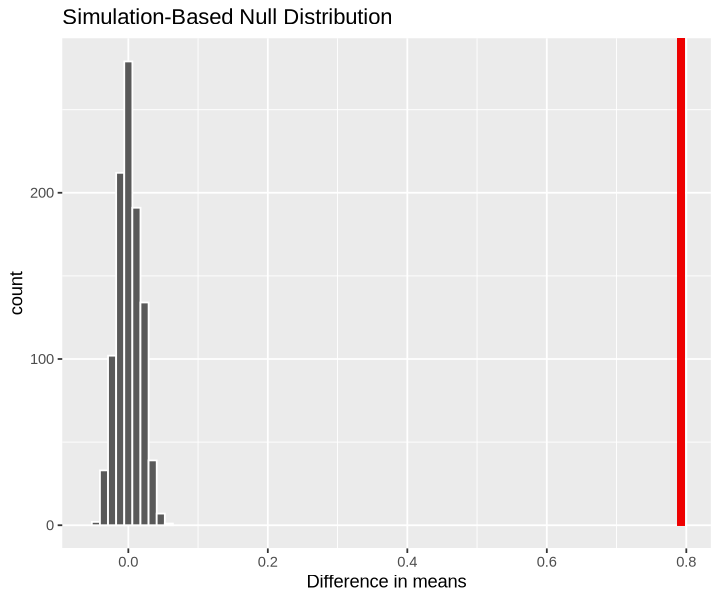

In [6]:
diff_in_means_plot
p_value

In [15]:
# now obtain our error probabilities
east_only <- real_estate_final |>
filter(town == "East Hartford")
n_east <- nrow(east_only)

west_only <- real_estate_final |>
filter(town == "West Hartford")
n_west <- nrow(west_only)
varwest <- var(scaled_west_data$sale_amount)

vareast <- var(scaled_east_data$sale_amount)

scaled_east_data <- east_only %>%
  mutate(across(c(sale_amount), scale))

scaled_west_data <- west_only %>%
  mutate(across(c(sale_amount), scale))


s <- sqrt((varwest / n_west) + (vareast / n_east))
s
obs_diff_in_means


hypothesis_errors <- tibble(type_I_error = 0.05,
                        type_II_error = 1-pnorm(qnorm(0.05, 0, s, obs_diff_in_means, s)), 
                        power_of_test = pnorm(qnorm(0.05, 0, s, obs_diff_in_means, s)))

hypothesis_errors

0.02332636


stat
<dbl>
175172


type_I_error,type_II_error,power_of_test
<dbl>,<dbl>,<dbl>
0.05,0.515303,0.484697


In [7]:
#s
obs_diff_in_means

stat
<dbl>
175172


## References

Real Estate Sales 2001-2020 GL. data.ct.gov, 9 Aug. 2023. Data.gov, 

    https://catalog.data.gov/dataset/real-estate-sales-2001-2018.
Real Estate Agents As a Source of Information for Home Buyers - HOUSTON - 1977 - Journal of Consumer Affairs - Wiley Online Library. 

    https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-6606.1977.tb00600.x. 
    
    Accessed 4 Nov. 2023.
    
Harnaga, Brandon J. Another Housing Bubble? A Review of Historical Indicators and Analysis of the Current State of the U.S. Residential Real Estate Market. May 2021. soar.suny.edu, 
    
    https://soar.suny.edu/handle/20.500.12648/1885.
